In [2]:
# Note: you may need to run the following in administrator mode in Windows, esp if you had to install spacy's language models
# as admin.  See the README for details.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *

import torchtext
import spacy
from torchtext import vocab, data
from torchtext.datasets import language_modeling

from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *

from sklearn.externals import joblib

import praw
import re
import random
import bs4, markdown

## Settings

In [3]:
# You definitely need to change this variable
target_subreddit = "INTP" #Subreddit you're targetting (without the /r/ portion)
#WARNING: if you pick a really popular subreddit, it'll take forever to download all of the posts!!!

# You may need to change these variables
test_portion = 0.1 #What fraction of the user's posts and submissions to use as the test set?
credential_file = "credentials.key"
bs = 16
bptt = 70
em_sz = 200  # size of each embedding vector
nh = 500     # number of hidden activations per layer
nl = 3       # number of layers

## Reddit Credentials

Make sure you create a [Reddit App](https://www.reddit.com/prefs/apps) named **fastai_reddit** and put the credentials in a file named "credentials.key" (or whatever name you picked in the cell above.)

Format your "credentials.key" file the following way:

1st line: PERSONAL USE SCRIPT (14 chars)  
2nd line: SECRET (27 chars)  
3rd line: REDDIT USERNAME  
4th line: REDDIT PASSWORD  


In [4]:
try:
    with open(credential_file, 'r') as f:
        creds = f.read().split('\n')
    personal = creds[0]
    secret = creds[1]
    username = creds[2]
    password = creds[3]
except IOError as e:
    print("You didn't create a credential file! Please see sample_credentials.key")
    print("Then go to http://www.storybench.org/how-to-scrape-reddit-with-python/")
    print("And register a new app named fastai_reddit in your reddit account.")
    print("And insert the values into sample_credentials.key and save it as {}.".format(credential_file))
    raise(e)

In [5]:
reddit = praw.Reddit(client_id=personal, client_secret=secret, user_agent='fastai_reddit', username=username, \
                     password=password)
subreddit = reddit.subreddit(target_subreddit)

In [6]:
def noquotes(text):
    """
This function first stated out as a way to remove markdown quotes from raw reddit markdown text but now it's more of a
general purpose text parser, but the name hasn't changed.
    """
    #https://stackoverflow.com/questions/761824/python-how-to-convert-markdown-formatted-text-to-text
    t1 = re.sub(">.+?(\n|$)","",text).replace("\\n","").replace("\\","")
    html = markdown.markdown(t1)
    t2 = ''.join(bs4.BeautifulSoup(html, 'lxml').findAll(text=True))
    
    return t2

In [7]:
# Test that our Reddit connection works
test = list(subreddit.top(limit=10))[0]
print(test.title)

Just ask an INTP


In [8]:
posts = list(subreddit.top(limit=None))

In [9]:
test = posts[0]
test_selftext = test.selftext
test_c = test.comments.list()[0]
print(noquotes(test_selftext))
print(test_c.body)


I choose to the think the asshole that painted the 6/9 (or 2/3) on the ground failed to put a line under the number to clarify what it was supposed to be.


In [15]:
def get_comment_text(comment):
    comments = []
    if isinstance(comment, praw.models.MoreComments):
        newcomments = comment.comments()
        for n in newcomments:
            comments += get_comment_text(n)
    else:
        comments.append(noquotes(comment.body))
    return comments
            

In [16]:
#WARNING: this step will take forever if you picked a really popular or active subreddit.
alltext = []
for p in posts:
    tmp = noquotes(p.selftext)
    if len(tmp) > 0:
        alltext.append(tmp)
    for c in p.comments.list():
        alltext += get_comment_text(c)

In [18]:
print(len(alltext))

56428


In [19]:
joblib.dump(alltext, target_subreddit + ".pkl")

['intp.pkl']

In [4]:
alltext = joblib.load(target_subreddit + ".pkl")

Now randomly join together posts and set aside a fraction of the posts equal to ```test_portion``` to designate as the test set.

In [5]:
random.shuffle(alltext)
split = round(test_portion*len(alltext))
train = pd.DataFrame()
test = pd.DataFrame()
test['text'] = alltext[0:split]
train['text'] = alltext[split:]

In [6]:
train.head()

,text
0,Stuff like data entry is not my normal job tas...
1,This.
2,I've been eyeing tiny homes for a bit. The ent...
3,Well I wasn’t really allowed to express emotio...
4,I feel like this is true to me. But I also fe...


In [7]:
test.head()

,text
0,"Aw, thank you <3"
1,Couldn't agree more. Yesterday I went to sleep...
2,"a lot of benefits, if you know someone is lyin..."
3,"I am always uncomfortable, even when I am comp..."
4,This is how literally everyone acts


In [23]:
len(train), len(test)

(50785, 5643)

In [24]:
TEXTS = data.Field(lower=True, tokenize="spacy")

In [25]:
#def from_dataframes(cls, path, field, col, train_df, val_df, test_df=None, bs=64, bptt=70, **kwargs):
#See: https://github.com/fastai/fastai/blob/master/fastai/nlp.py
md = LanguageModelData.from_dataframes(path="./", field=TEXTS, col='text',train_df=train,val_df=test,\
                                       test_df=test,bs=bs, bptt=bptt)

In [26]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

You may need to change the dropouts below if you're overfitting

In [27]:
learner = md.get_model(opt_fn, em_sz, nh, nl,
               dropout=0.05, dropouth=0.1, dropouti=0.05, dropoute=0.02, wdrop=0.2)
learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.clip=0.3

In [28]:
learner.lr_find()

 84%|████████████████████████████████████████████████████████▉           | 928/1109 [03:52<00:45,  3.98it/s, loss=21.3]

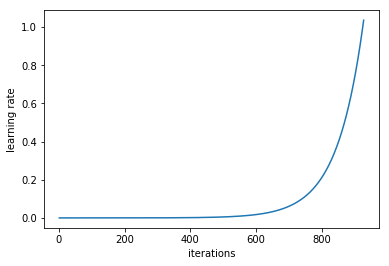

In [29]:
learner.sched.plot_lr()

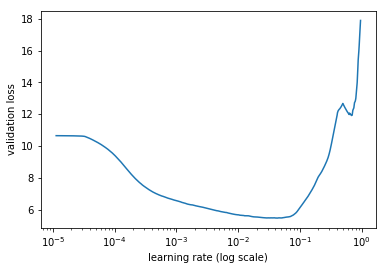

In [30]:
learner.sched.plot()

Set the learning rate to the largest power of 10 that is less than the rate that gives your lowest "validation loss".

In [31]:
lr = 3e-3

In [32]:
learner.fit(lr, 4, wds=1e-6, cycle_len=1, cycle_mult=2)
#Note: if you get an error, try reducing the batch size!
#Feel free to terminate training prematurely if val_loss isn't improving

RuntimeError: cuda runtime error (2) : out of memory at d:\pytorch\pytorch\torch\lib\thc\generic/THCStorage.cu:58

In [54]:
learner.save_encoder('subreddit_' + target_subreddit + "_enc")


In [ ]:
learner.load_encoder('subreddit_' + target_subreddit + "_enc")

In [212]:
learner.fit(lr, 1, wds=1e-6, cycle_len=10)
#Feel free to terminate training prematurely if val_loss isn't improving

epoch      trn_loss   val_loss                                                                                         
    0      4.56414    5.365735  
    1      4.709426   5.295075                                                                                         
    2      4.691909   5.392634                                                                                         
    3      4.656178   5.475455                                                                                         
    4      4.656554   5.382054                                                                                         
    5      4.582662   5.44813                                                                                          
    6      4.527119   5.43926                                                                                          
    7      4.496453   5.463637                                                                                         
    8  

[array([5.43082])]

## Set your "seed string" below
(Or leave it as the default if you want it to pick a random post from your test set.)

In [61]:
ss = random.choice(test['text'])
#ss="""The right way """

In [67]:
def proc_str(s): return TEXTS.preprocess(TEXTS.tokenize(s))
def num_str(s): return TEXTS.numericalize([proc_str(s)])

m=learner.model

def sample_model(m, s, l=50):
    t = num_str(s)
    m[0].bs=1
    m.eval()
    m.reset()
    res,*_ = m(t)
    print('...', end='')

    for i in range(l):
        n=res[-1].topk(2)[1]
        n = n[1] if n.data[0]==0 else n[0]
        word = TEXTS.vocab.itos[n.data[0]]
        print(word, end=' ')
        if (word=='<eos>') or (word=='< eos >'): break
        res,*_ = m(n[0].unsqueeze(0))

    m[0].bs=bs

In [62]:
sample_model(m,ss)

...< eos > i agree with this in spirit , but an important lesson i 've learned over time is that you really need to pick your battles . sometimes it 's immediately apparent that no amount of brilliant logic is going to make a difference , and in the 

In [58]:
sample_model(m,"<CAT> csni <SUMM> algorithms that")

...case i 'm not saying i 'm not say what 's the particularly thing is , but i respect people who believe they can and strive toward that end . i might even help them sometimes even if my cheering is less passionate than theirs .   < eos > 

In [59]:
sample_model(m,"<CAT> cscv <SUMM> algorithms that")

...case i 'm not saying i 'm not say what 's the particularly thing is , but i respect people who believe they can and strive toward that end . i might even help them sometimes even if my cheering is less passionate than theirs .   < eos > 

In [60]:
sample_model(m,"<CAT> cscv <SUMM> algorithms. <TITLE> on ")

...both playing cards and dice . < eos > i agree with this in spirit , but an important lesson i 've learned over time is that you really need to pick your battles . sometimes it 's immediately apparent that no amount of brilliant logic is going to make 

In [63]:
sample_model(m,"<CAT> csni <SUMM> algorithms. <TITLE> on ")

...both playing cards and dice . < eos > i agree with this in spirit , but an important lesson i 've learned over time is that you really need to pick your battles . sometimes it 's immediately apparent that no amount of brilliant logic is going to make 

In [65]:
sample_model(m,"INTJs")

.... 
 i 'm not really really know what 's just like it 's an intp , but i just do n't think that 's a particularly vague question . 
 i think the majority of questions probably have more than one answer , i ca n't think of anything 

In [68]:
sample_model(m,"ENTJs")

.... 
 i 'm not saying what 's just like it 's an an 8 . the guy just ran out of paint . < eos > i agree with this in spirit , but an important lesson i 've learned over time is that you really need to pick 

In [93]:
sample_model(m,"work")

..., and i just do n't think it 's a nine .   but , it is white because the fill is white . " 
 this is what i perceive in arguments most of the time .   both can clearly see each other 's perspective , but actively 